In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import cv2
print(cv2.__version__)

sns.set(style="whitegrid")

train_csv_path = os.path.join('..','data', 'train_labels.csv')
df = pd.read_csv(train_csv_path)

df.rename(columns={'Bags used': 'bags_used', 'Pothole number': 'pothole_number'}, inplace=True)


4.10.0


In [2]:
df.head()
print(df.columns)


Index(['pothole_number', 'Bags used '], dtype='object')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pothole_number  644 non-null    int64  
 1   Bags used       644 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 10.2 KB


## Distribution of the target variable

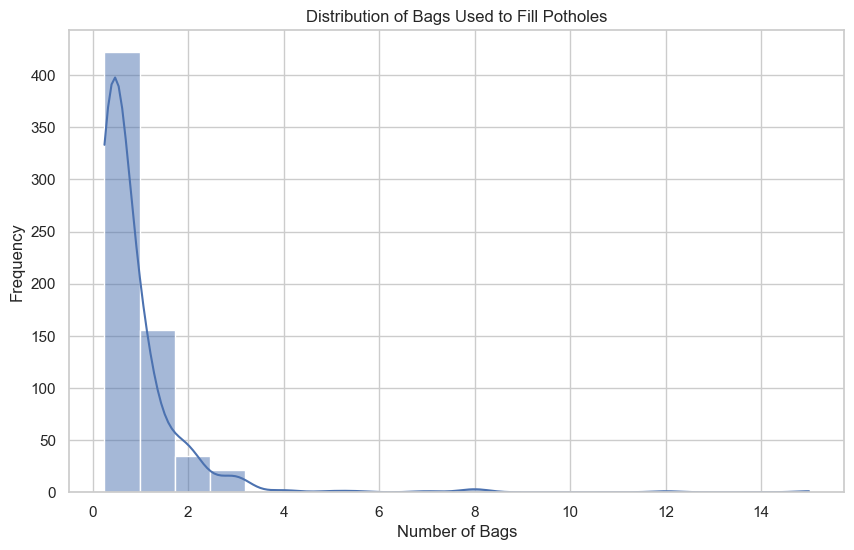

In [4]:
df.rename(columns={'Bags used ': 'bags_used'}, inplace=True)
df.rename(columns={'Pothole number': 'pothole_number'}, inplace=True)


plt.figure(figsize=(10, 6))
sns.histplot(df['bags_used'], kde=True, bins=20)
plt.title('Distribution of Bags Used to Fill Potholes')
plt.xlabel('Number of Bags')
plt.ylabel('Frequency')
plt.show()



In [5]:

description = df['bags_used'].describe()
print(description)

value_counts = df['bags_used'].value_counts().sort_index()
print("\nCount of each unique value in 'bags_used':")
print(value_counts)


count    644.000000
mean       0.865140
std        1.121281
min        0.250000
25%        0.500000
50%        0.500000
75%        1.000000
max       15.000000
Name: bags_used, dtype: float64

Count of each unique value in 'bags_used':
bags_used
0.25     140
0.50     278
0.55       4
1.00     116
1.05       3
1.50      35
1.55       2
2.00      34
2.05       1
2.50       7
3.00      12
3.05       1
3.10       1
4.00       2
5.00       1
5.50       1
7.00       1
8.00       3
12.00      1
15.00      1
Name: count, dtype: int64


## Reading the YOLO Annotations

In [6]:
def read_yolo_annotation(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    annotations = []
    for line in lines:
        parts = line.strip().split()
        label = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        annotations.append((label, x_center, y_center, width, height))
    return annotations


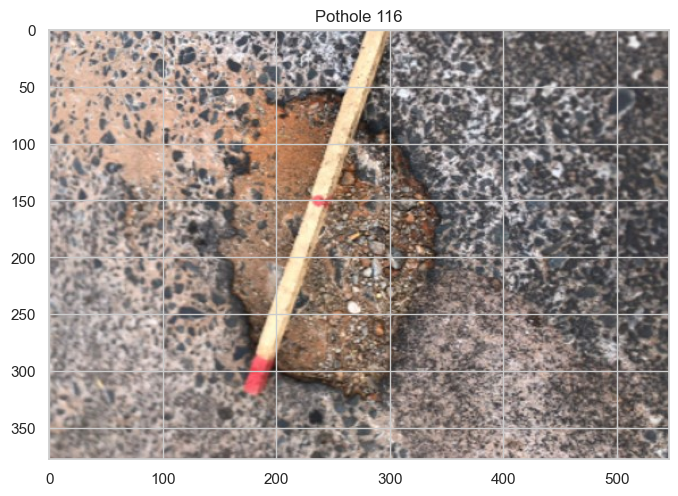

In [7]:
pothole_id = 116

# Construct file paths based on the pothole id
image_filename = f'p{pothole_id}.jpg'
annotation_filename = f'p{pothole_id}.txt'

sample_image_path = os.path.join('..','data', 'train_images', image_filename)
sample_annotation_path = os.path.join('..','data', 'train_annotations', annotation_filename)

# Load and display the image
image = cv2.imread(sample_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.title(f'Pothole {pothole_id}')
plt.show()

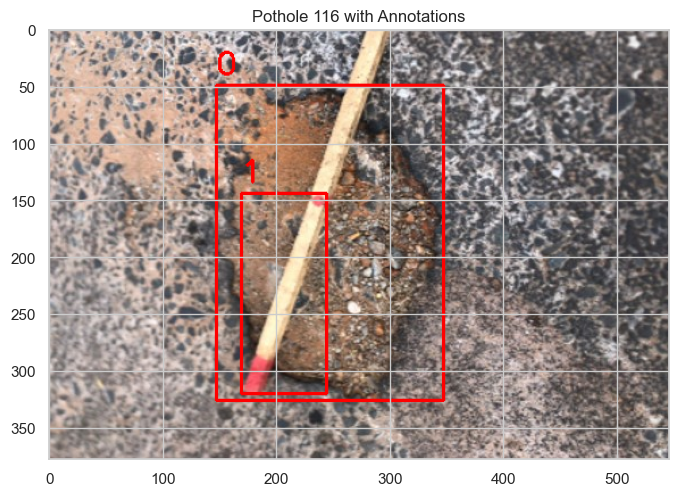

Details for Pothole 116:
    pothole_number  bags_used
10             116        1.0


In [8]:
annotations = read_yolo_annotation(sample_annotation_path)

# Convert YOLO format to bounding box coordinates and draw them on the image
image_height, image_width, _ = image.shape
for annotation in annotations:
    label, x_center, y_center, width, height = annotation
    x_min = int((x_center - width / 2) * image_width)
    x_max = int((x_center + width / 2) * image_width)
    y_min = int((y_center - height / 2) * image_height)
    y_max = int((y_center + height / 2) * image_height)
    cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    cv2.putText(image_rgb, str(label), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Display the image with annotations
plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.title(f'Pothole {pothole_id} with Annotations')
plt.show()

# Display the corresponding row in the train_labels.csv
pothole_info = df[df['pothole_number'] == pothole_id]
print(f"Details for Pothole {pothole_id}:")
print(pothole_info)

In [9]:
#Calculate pothole area from bounding boxes
def calculate_area(annotations, image_width, image_height):
    areas = []
    for annotation in annotations:
        _, x_center, y_center, width, height = annotation
        x_min = (x_center - width / 2) * image_width
        x_max = (x_center + width / 2) * image_width
        y_min = (y_center - height / 2) * image_height
        y_max = (y_center + height / 2) * image_height
        area = (x_max - x_min) * (y_max - y_min)
        areas.append(area)
    return areas

# Calculate the area of the pothole in pixels
areas = calculate_area(annotations, image_width, image_height)
pothole_area = sum(areas)
print(f"Total area of Pothole {pothole_id}: {pothole_area} pixels")

Total area of Pothole 116: 68322.99362890857 pixels


In [10]:
# Compute aspect ratios of potholes
aspect_ratios = [width / height for _, _, _, width, height in annotations]
print("Aspect Ratios of the Pothole:")
print(aspect_ratios)

Aspect Ratios of the Pothole:
[0.4977478738263207, 0.29633828632402326]


In [11]:
# Extract color information from pothole regions
def extract_color_info(image, annotations):
    colors = []
    for annotation in annotations:
        _, x_center, y_center, width, height = annotation
        x_min = int((x_center - width / 2) * image_width)
        x_max = int((x_center + width / 2) * image_width)
        y_min = int((y_center - height / 2) * image_height)
        y_max = int((y_center + height / 2) * image_height)
        roi = image[y_min:y_max, x_min:x_max]
        roi_mean = np.mean(roi, axis=(0, 1))
        colors.append(roi_mean)
    return colors

# Extract color information from the pothole regions
colors = extract_color_info(image, annotations)
print("Mean Color Information of the Pothole Regions:")
print(colors)


Mean Color Information of the Pothole Regions:
[array([102.90447653, 117.1551444 , 138.96247292]), array([109.91643939, 129.27643939, 157.76530303])]


Conversion factor: 4.7468 mm/pixel
Pothole area: 1241692.84 sq mm
Pothole width: 944.85 mm
Pothole height: 1314.17 mm


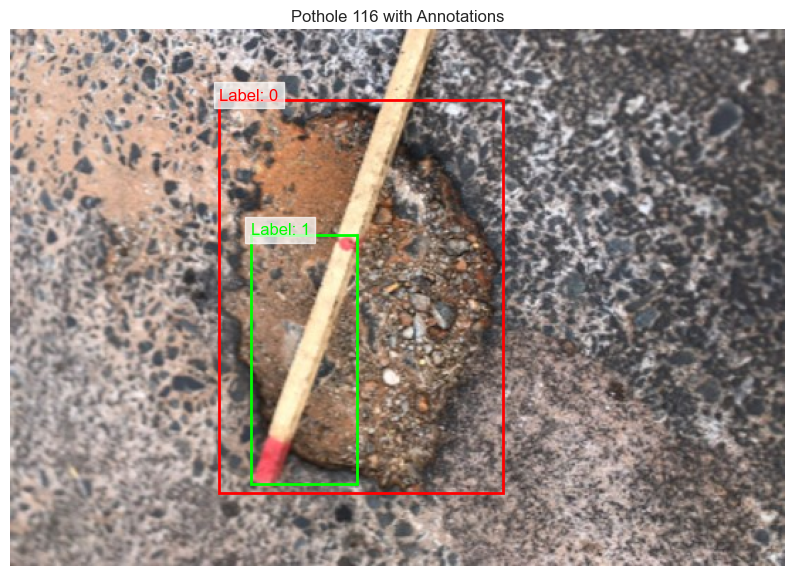


All annotations:
Annotation 0: Label 0, Center: (0.45, 0.50), Size: (0.36, 0.73)
Annotation 1: Label 1, Center: (0.38, 0.61), Size: (0.14, 0.46)


In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_yolo_annotation(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    annotations = []
    for line in lines:
        parts = line.strip().split()
        label = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        annotations.append((label, x_center, y_center, width, height))
    return annotations

def pixel_to_mm_conversion(annotations, image_width, image_height):
    l1_annotation = next((ann for ann in annotations if ann[0] == 1), None)
    
    if l1_annotation:
        _, _, _, width, height = l1_annotation
        pixel_width = width * image_width
        pixel_height = height * image_height
        
        # L1 true length is 500mm
        mm_per_pixel_width = 500 / pixel_width
        mm_per_pixel_height = 500 / pixel_height
        
        # Use the average of width and height conversion factors
        mm_per_pixel = (mm_per_pixel_width + mm_per_pixel_height) / 2
        
        return mm_per_pixel
    else:
        return None

# Use the same pothole_id you were using before
pothole_id = 116

# Construct file paths based on the pothole id
image_filename = f'p{pothole_id}.jpg'
annotation_filename = f'p{pothole_id}.txt'

sample_image_path = os.path.join('..', 'data', 'train_images', image_filename)
sample_annotation_path = os.path.join('..', 'data', 'train_annotations', annotation_filename)

# Load the image and annotations
image = cv2.imread(sample_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_height, image_width, _ = image.shape

annotations = read_yolo_annotation(sample_annotation_path)

# Calculate the pixel-to-millimeter conversion factor
mm_per_pixel = pixel_to_mm_conversion(annotations, image_width, image_height)

if mm_per_pixel:
    print(f"Conversion factor: {mm_per_pixel:.4f} mm/pixel")

    # Calculate pothole area in square millimeters
    pothole_annotation = next((ann for ann in annotations if ann[0] == 0), None)
    if pothole_annotation:
        _, _, _, width, height = pothole_annotation
        pothole_width_pixels = width * image_width
        pothole_height_pixels = height * image_height
        pothole_area_pixels = pothole_width_pixels * pothole_height_pixels
        pothole_area_mm2 = pothole_area_pixels * (mm_per_pixel ** 2)
        
        print(f"Pothole area: {pothole_area_mm2:.2f} sq mm")
        print(f"Pothole width: {pothole_width_pixels * mm_per_pixel:.2f} mm")
        print(f"Pothole height: {pothole_height_pixels * mm_per_pixel:.2f} mm")
    else:
        print("No pothole annotation (label 0) found.")
else:
    print("No L1 measurement (label 1) found in the annotations. Unable to perform conversion.")

# Visualize the image with annotations
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)

for ann in annotations:
    label, x_center, y_center, width, height = ann
    x_min = int((x_center - width/2) * image_width)
    y_min = int((y_center - height/2) * image_height)
    x_max = int((x_center + width/2) * image_width)
    y_max = int((y_center + height/2) * image_height)
    
    color = (1, 0, 0) if label == 0 else (0, 1, 0)  # Red for pothole, Green for L1
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                      fill=False, edgecolor=color, linewidth=2))
    plt.text(x_min, y_min, f"Label: {label}", color=color, fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.7))

plt.title(f'Pothole {pothole_id} with Annotations')
plt.axis('off')
plt.show()

# Print all annotations for debugging
print("\nAll annotations:")
for i, ann in enumerate(annotations):
    print(f"Annotation {i}: Label {ann[0]}, Center: ({ann[1]:.2f}, {ann[2]:.2f}), Size: ({ann[3]:.2f}, {ann[4]:.2f})")